# **Customer Propensity Model for Promotion Response**

Jingqi Zhuang

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random_state = 42

# **Part 1: Load Data**

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/RSM8521/Assignment3'

promos = pd.read_csv(path + '/promos.csv.gz')
train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
transactions = pd.read_parquet(path + '/transactions.parquet')

# **Part 2: Feature Engineering**

## **2.1 Promo Data**

Add promotion information to the train and test history.

In [ ]:
def merge_promos(df):

  # merge promos based on promo id
  features = df.merge(promos, on='promo', how='left')

  # drop column: promo id
  features.drop('promo', axis=1, inplace=True)

  # all promotion has same promoqty -> useless information
  # drop promoqty
  print(features['promoqty'].nunique() == 1)
  features.drop('promoqty', axis=1, inplace=True)

  return features

In [ ]:
features = merge_promos(train_history)
predict_features = merge_promos(test_history)

True
True


## **2.2 Transaction Data**
Extract information from transaction data.

### **Compute RFM Features**

- recency: Time since last purchase

- frequency: average number of purchases per day

- monetary: total dollar amount spent


In [ ]:
def compute_rfm(transactions, features):

  max_date = transactions.date.max()
  transactions['last_purchase'] = (max_date - transactions['date']) / np.timedelta64(1, "D")

  # Agg transaction data to id
  trans_features = transactions.groupby('id').agg({
      'last_purchase': 'min',
      'date': ['nunique', 'min'],
      'amt': 'sum',
  })

  # Compute RFM columns
  trans_features['recency'] = trans_features['last_purchase']['min']
  trans_features['frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
  trans_features['monetary'] = trans_features['amt']['sum']


  # Select out required features
  trans_features = trans_features[['recency', 'frequency', 'monetary']].reset_index()
  trans_features.columns = trans_features.columns.get_level_values(0)

  # merge trans_features to features
  features = features.merge(trans_features, on='id', how='left')
  features['recency'].fillna(365, inplace=True)
  features['frequency'].fillna(0, inplace=True)
  features['monetary'].fillna(0, inplace=True)

  return features

In [ ]:
features = compute_rfm(transactions, features)
predict_features = compute_rfm(transactions, predict_features)

### **Product Level**


`market_group_count`: compute the times of transactions from each market_group per id

In [ ]:
# category to market group mapping
category_to_market_group = transactions[['market_group', 'category']].drop_duplicates()

# add market group to features
features = features.merge(category_to_market_group, on='category', how='left')
predict_features = predict_features.merge(category_to_market_group, on='category', how='left')

In [ ]:
def count_freq(transactions, col, features):

  # Count transactions per id and col
  freq = transactions.groupby(['id', col]).size().reset_index(name=f'{col}_count')
  result = freq[['id', col, f'{col}_count']]

  # merge results to features
  features = features.merge(result, on=['id', col], how='left')

  # if missing values, fill with 0
  features[f'{col}_count'] = features[f'{col}_count'].fillna(0)

  return features

In [ ]:
features = count_freq(transactions, 'market_group', features)
predict_features = count_freq(transactions, 'market_group', predict_features)

`brand_count`: compute the times of transactions from each brand per id

In [ ]:
features = count_freq(transactions, 'brand', features)
predict_features = count_freq(transactions, 'brand', predict_features)

`amt_per_qty`: Dollar amount spent per unit of product at a specific store.

In [ ]:
def compute_amt_per_qty(transactions, features):

  # remove transaction with negative quantity and amount (ignore transactions that return items)
  no_return = transactions[(transactions['amt'] > 0) & (transactions['qty'] > 0)]

  # count amount per quantity
  no_return['amt_per_qty'] = no_return['amt'] / no_return['qty']

  # product-level info
  transactions_product = no_return[['store', 'category', 'manufacturer',
                                    'brand', 'amt_per_qty']].drop_duplicates()

  # merge to features
  features = features.merge(transactions_product, on=['store', 'category',
                                                      'manufacturer', 'brand'],
                            how='left')

  # keep category, remove market_group
  features.drop('market_group', axis=1, inplace=True)

  return features

In [ ]:
features = compute_amt_per_qty(transactions, features)
predict_features = compute_amt_per_qty(transactions, predict_features)

In [ ]:
# there are different amount per quantity for different dates
# get the average dollar value per quantity for each product in each store
def compute_avg_amt_per_qty(features):

  features_cols = list(features.columns)
  features_cols.remove('amt_per_qty')
  features_cols.remove('active')

  avg_amt = features.groupby(features_cols)['amt_per_qty'].mean().reset_index(name='avg_amt_per_qty')
  features = features.merge(avg_amt, on=features_cols, how='left')
  features.drop('amt_per_qty', axis=1, inplace=True)
  features = features.drop_duplicates()

  return features

In [ ]:
features = compute_avg_amt_per_qty(features)
predict_features = compute_avg_amt_per_qty(predict_features)

## **2.3 Train and Test History**


Convert `promodate` to `promo_weekday`

In [ ]:
def promo_weekdays(features):
  # convert promodate to promo_weekday
  features['promo_weekday'] = features['promodate'].dt.dayofweek
  weekday_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
  features['promo_weekday'] = features['promo_weekday'].map(weekday_mapping)

  # remove promodate
  features.drop('promodate', axis=1, inplace=True)

  return features

In [ ]:
features = promo_weekdays(features)
predict_features = promo_weekdays(predict_features)

In [ ]:
features['promo_weekday'].value_counts()

,count
promo_weekday,
Mon,3699
Wed,3581
Tue,3198
Sat,3014
Fri,2819
Thu,2345
Sun,1344


column `store`
- there are 105 unique stores in the training set
- there are 3807 training records from store 625933, 1523 test records from store 625933
- create feature `store_625933`

In [ ]:
features['store'].nunique()

105

In [ ]:
predict_features['store'].value_counts().head(5)

,count
store,
625933,1523
457755,1040
876095,519
394092,405
740794,342


In [ ]:
features['store'].value_counts().head(5)

,count
store,
625933,3807
527828,1556
876095,1152
285434,906
441373,804


In [ ]:
features['store_625933'] = (features['store'] == 625933).astype(int)
predict_features['store_625933'] = (predict_features['store'] == 625933).astype(int)

features.drop('store', axis=1, inplace=True)
predict_features.drop('store', axis=1, inplace=True)

column `category`

- 8 categories in training set, 11 categories in test set
- category 42760698 has 10388 records in training set, 1196 records in test set
- category 51006740 has 1943 records in training set, 1667 records in test set

In [ ]:
features['category'].value_counts()

,count
category,
42760698,10388
75228190,4522
56844954,2142
51006740,1943
8946099,411
20487740,310
81382162,266
55115791,18


In [ ]:
predict_features['category'].value_counts()

,count
category,
59128902,1993
79950300,1968
51006740,1667
42760698,1196
50883796,980
17240091,779
81382162,577
75536470,487
20487740,318


In [ ]:
features['category_42760698'] = (features['category'] == 42760698).astype(int)
predict_features['category_42760698'] = (predict_features['category'] == 42760698).astype(int)

features['category_51006740'] = (features['category'] == 51006740).astype(int)
predict_features['category_51006740'] = (predict_features['category'] == 51006740).astype(int)

In [ ]:
features.drop('category', axis=1, inplace=True)
predict_features.drop('category', axis=1, inplace=True)

In [ ]:
features['category_42760698'].value_counts()

,count
category_42760698,
1,10388
0,9612


In [ ]:
features['category_51006740'].value_counts()

,count
category_51006740,
0,18057
1,1943


column `brand`
- 6 brands in training set, 10 brands in test set
- brand 1386413202 has 10388 records in training set, 1196 records in test set
- brand 324788825 has 594 records in training set, 923 records in test set

In [ ]:
features['brand'].value_counts()

,count
brand,
1386413202,10388
1234009542,4522
1429623935,2142
189092190,1943
324788825,594
86145108,411


In [ ]:
predict_features['brand'].value_counts()

,count
brand,
704691081,1993
649187428,1968
854156277,1639
1386413202,1196
885846981,980
324788825,923
2395929821,779
1893579944,487
189092190,28


In [ ]:
features['brand_1386413202'] = (features['brand'] == 1386413202).astype(int)
predict_features['brand_1386413202'] = (predict_features['brand'] == 1386413202).astype(int)

features['brand_324788825'] = (features['brand'] == 324788825).astype(int)
predict_features['brand_324788825'] = (predict_features['brand'] == 324788825).astype(int)

features.drop('brand', axis=1, inplace=True)
predict_features.drop('brand', axis=1, inplace=True)

In [ ]:
features['brand_1386413202'].value_counts()

,count
brand_1386413202,
1,10388
0,9612


In [ ]:
features['brand_324788825'].value_counts()

,count
brand_324788825,
0,19406
1,594


column `manufacturer`

- there are 6 manufacturers in training set, 9 manufacturers in test set

- manufacturer 1957688344 has 10388 records in training set, 1196 records in test set
- manufacturer 122801592 has 594 records in training set, 2916 records in test set

In [ ]:
features['manufacturer'].value_counts()

,count
manufacturer,
1957688344,10388
1154816776,4522
629075831,2142
1593002228,1943
122801592,594
1150283635,411


In [ ]:
predict_features['manufacturer'].value_counts()

,count
manufacturer,
122801592,2916
107216507,1968
2037186963,1639
1957688344,1196
324835488,980
376504989,779
266826345,487
1593002228,28
1150283635,7


In [ ]:
features['manufacturer_1957688344'] = (features['manufacturer'] == 1957688344).astype(int)
predict_features['manufacturer_1957688344'] = (predict_features['manufacturer'] == 1957688344).astype(int)

features['manufacturer_122801592'] = (features['manufacturer'] == 122801592).astype(int)
predict_features['manufacturer_122801592'] = (predict_features['manufacturer'] == 122801592).astype(int)

features.drop('manufacturer', axis=1, inplace=True)
predict_features.drop('manufacturer', axis=1, inplace=True)

In [ ]:
features['manufacturer_1957688344'].value_counts()

,count
manufacturer_1957688344,
1,10388
0,9612


In [ ]:
features['manufacturer_122801592'].value_counts()

,count
manufacturer_122801592,
0,19406
1,594


Column `region`

- top 6 regions

In [ ]:
features['region'].value_counts().head(6)

,count
region,
191747,4460
165933,2178
323706,1152
36431,1127
115119,1001
243820,880


In [ ]:
region_mapping = {
    191747: '191747',
    165933: '165933',
    323706: '323706',
    36431: '36431',
    115119: '115119',
    243820: '243820'
}

features['region'] = features['region'].map(region_mapping).fillna('other')
predict_features['region'] = predict_features['region'].map(region_mapping).fillna('other')

In [ ]:
features['region'].value_counts()

,count
region,
other,9202
191747,4460
165933,2178
323706,1152
36431,1127
115119,1001
243820,880


# **Part 3: Data Pre-processing**

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 385736
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       20000 non-null  int64  
 1   region                   20000 non-null  object 
 2   active                   20000 non-null  float64
 3   promoval                 20000 non-null  float64
 4   recency                  20000 non-null  float64
 5   frequency                20000 non-null  float64
 6   monetary                 20000 non-null  float32
 7   market_group_count       20000 non-null  float64
 8   brand_count              20000 non-null  float64
 9   avg_amt_per_qty          19157 non-null  float64
 10  promo_weekday            20000 non-null  object 
 11  store_625933             20000 non-null  int64  
 12  category_42760698        20000 non-null  int64  
 13  category_51006740        20000 non-null  int64  
 14  brand_1386413202         2

Convert categorical variables into dummy variables

In [ ]:
dummy_col = ['region', 'promo_weekday']

features = pd.get_dummies(features, columns=dummy_col, drop_first=True)
predict_features = pd.get_dummies(predict_features, columns=dummy_col, drop_first=True)

# training and prediction set have same columns
(features.columns == predict_features.columns).all()

np.True_

Normalize numerical columns

In [ ]:
scale_col = ['recency', 'monetary', 'frequency', 'avg_amt_per_qty', 'promoval', 'market_group_count', 'brand_count']

scaler = MinMaxScaler()
features[scale_col] = scaler.fit_transform(features[scale_col])
predict_features[scale_col] = scaler.transform(predict_features[scale_col])

In [ ]:
# identify predictors and target variable
x_cols = features.columns.difference(['active', 'id'])
y_col = 'active'

Fill missing values for column `avg_amt_per_qty`

- Iterative Imputer (MICE): Uses multivariate regression to predict missing values iteratively.

In [ ]:
imputer = IterativeImputer(random_state=random_state, max_iter=10)
X_imputed = imputer.fit_transform(features[x_cols])
X_predict_imputed = imputer.transform(predict_features[x_cols])

### **Generate train, test and prediction sets**

In [ ]:
X = pd.DataFrame(X_imputed, columns=x_cols)
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

# make sure the target variable is 0 or 1
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
# Generate prediction set (for blind test)
X_predict = pd.DataFrame(X_predict_imputed, columns=x_cols)
predict_out = predict_features[['id', 'active']].copy()

In [ ]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_predict.isna().sum().sum())

0
0
0


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_predict.shape)

(16000, 26)
(4000, 26)
(10000, 26)


# **Part 4: Build Model**


## **4.1 Build Model with Cross-Validation**

In [ ]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    max_depth=6,
    random_state=random_state
)

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    class_weight='balanced',
    use_label_encoder=False,
    random_state=random_state
)

In [ ]:
# use stacking classifier to combine all classifiers together
model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

In [ ]:
def evaluate_model_cv(model, X=X_train, y=y_train, cv=5, random_state=random_state):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    acc_scores = []
    auc_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        acc_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))

    print(f"Accuracy: {(np.mean(acc_scores) - np.std(acc_scores), np.mean(acc_scores) + np.std(acc_scores))}")
    print(f"ROC AUC:  {(np.mean(auc_scores) - np.std(auc_scores), np.mean(auc_scores) + np.std(auc_scores))}")

In [ ]:
# evaluate_model_cv(model)

## **4.3 Evaluate Model Performance using Test Set**

- `X_test, y_test`

In [ ]:
model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              class_weight='balanced',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interacti...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       n_estimators=1000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [ ]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
y_prob = model.predict_proba(X_test)[:, 1]
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, y_prob)))

Test Accuracy: 0.65
Test AUC: 0.70


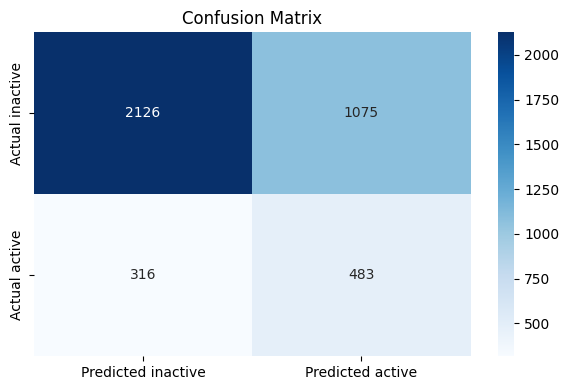

False Negative Rate: 0.40
False Positive Rate: 0.34


In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted inactive', 'Predicted active'],
            yticklabels=['Actual inactive', 'Actual active'])
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print('False Negative Rate: {:.2f}'.format(cm[1, 0] / (cm[1, 0] + cm[1, 1])))
print('False Positive Rate: {:.2f}'.format(cm[0, 1] / (cm[0, 0] + cm[0, 1])))

## **4.4 Fit the Model Using Entire Training Set**

- Entire Training Set: `X`

In [ ]:
model.fit(X, y)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              class_weight='balanced',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interacti...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       n_estimators=1000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

# **Part 5: Generate Prediction**

- `X_predict`

In [ ]:
predict_out['active'] = model.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.601077
13,61214568335,0.332623
15,274776763999,0.815551
21,91546215019,0.649450
31,220718580189,0.468671


In [ ]:
predict_out.to_csv('predict.csv', header=True, index=False)

In [ ]:
# This will download your prediction files
from google.colab import files
files.download('predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>